# Random Forest Classifier Canada France Imaging Survery
 This notebook develops a machine learning algorithm using the Random Forest architecture to discern dwarf and giant stars in the CFIS/Pan-STARRS/Segue catalogue. CFIS is an ongoing survery at the Canada France Hawaii Telescope. 
 
 Author: Nic Annau, University of Victoria
 Date: October, 2018
 Requirements: catalogue.py (and all packages contained within),


In [64]:
from catalogue import * # From catalogue.py containing all relevant subroutines. 
import seaborn as sns

import warnings # Ignore some deprecation warnings between scipy and pandas
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('ticks')

Load training data - augments using a Monte Carlo simulation, filters, and gets information from FITS image. See load_data() for more information.

In [65]:
inputs, outputs, error, df_original = load_data()
print "Total number of stars after some quality cuts:", inputs.shape[0]

Total number of stars after some quality cuts: 142470


Remove A-type stars using u and g band color cut, poorly measured spectral features in $\log{g}$, and stars that are neither giant or a dwarf with colors less than 0.5.

In [66]:
# Select only the highest allowed error in logg
logg_error_thres = 0.16
# Create logg cut condition
logg_cut = (error['dlogg'] <= logg_error_thres)

# Remove A-types from a line of the form :
a_conta=0.42
b_conta=-0.3

# To remove the contaminent stars (i.e. that are not giants or dwarfs
ug_cut=0.5

# Create A-type star cut condition
a_type_cut = (a_conta*(inputs['u']-inputs['g'])+b_conta<=(inputs['g']-inputs['r'])) & (inputs['u']-inputs['g']>=ug_cut)

# Apply each condition to the loaded data so that the input, output, and error data reference the same stars.
a_stars = inputs[a_type_cut].reset_index(drop=True)
outputs = outputs[logg_cut & a_type_cut].reset_index(drop=True)
error = error[logg_cut & a_type_cut].reset_index(drop=True)

print "Number stars before cuts", inputs.shape
print "Number stars after cuts", a_stars.shape

Number stars before cuts (142470, 9)
Number stars after cuts (134061, 9)


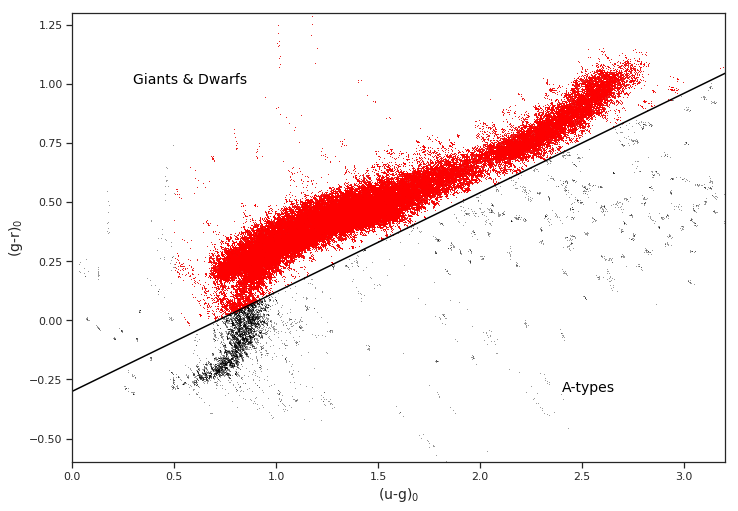

In [67]:
sns.scatterplot(inputs['u']-inputs['g'],inputs['g']-inputs['r'],marker='o', s=1, linewidth=0, color='black', alpha=0.5, legend='full')
sns.scatterplot(a_stars['u']-a_stars['g'], a_stars['g']-a_stars['r'],marker='o', linewidth=0, s=1, color='red', legend='full')

line=np.arange(0.0,3.5,0.002)
sns.lineplot(line, 0.42*line-0.3, color='black')

plt.xlabel('(u-g)$_0$',fontsize=14)
plt.ylabel('(g-r)$_0$',fontsize=14)

plt.xlim(0.0,3.2)
plt.ylim(-0.6,1.3)
plt.ylabel('(g-r)$_0$')
plt.annotate(r"Giants & Dwarfs", xy=(0.3,1.0), xytext=(0.3, 1.0), color='black',size=14)
plt.annotate(r"A-types", xy=(2.4,-0.3), xytext=(2.4, -0.3), color='black',size=14)

# Apply plotted cut
inputs = inputs[logg_cut & a_type_cut]

Assign 'dwarf' or 'giant' for the classifier based on a $\log{g}$ of 3.5

In [68]:
# For binary classification, we need to set the threshold for which
# logg we decide is a dwarf or a giant

outputs['logg_binary'] = np.where(outputs['logg'] > 3.5, 'dwarf', 'giant')

In [69]:
# Shuffle the dataframes randomly to remove any sequencing biases.

seed = random.randint(1, 101) # Get random integer to shuffle the inputs and outputs randomly, but the same way
inputs = inputs.sample(frac=1, random_state = seed).reset_index(drop=True)
outputs = outputs.sample(frac=1, random_state = seed).reset_index(drop=True)

In [70]:
# Using dimensionality reduction to create the training features in a new dataframe
inputs_col = pd.DataFrame()

inputs_col['u-g']=inputs['u']-inputs['g']
inputs_col['g-r']=inputs['g']-inputs['r']
inputs_col['r-i']=inputs['r']-inputs['i']
inputs_col['i-z']=inputs['i']-inputs['z']
inputs_col['z-y']=inputs['z']-inputs['y']
inputs_col['u-G']=inputs['u']-inputs['G']
inputs_col['u-RP']=inputs['u']-inputs['RP']
inputs_col['u-BP']=inputs['u']-inputs['BP']

In [71]:
# Normalize the data using custom normalize function
# default is using mean and stdev. 
inputf = normalize(inputs_col).dropna()
outputf = normalize(outputs).dropna()

Check normalization, check that monte carlo worked properly. 

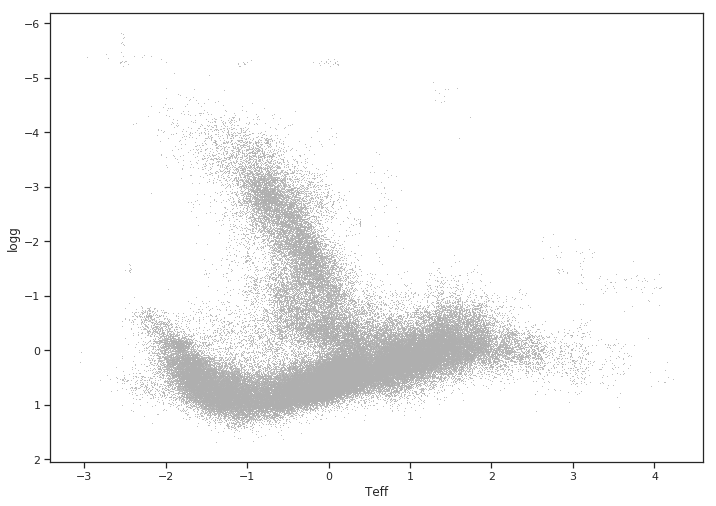

In [72]:
sns.scatterplot(outputf['Teff'], outputf['logg'], linewidth=0, markers='.', color='black', s=0.7)
plt.gca().invert_yaxis()

Check the density distribution

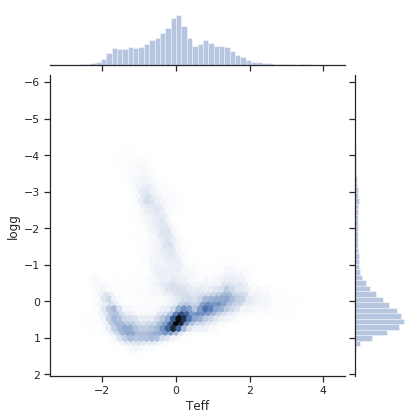

In [73]:
sns.jointplot(x=outputf['Teff'], y=outputf['logg'], kind="hex", color="b")
plt.gca().invert_yaxis()

Split the inputs and outputs into test and train datasets. To ensure each split randomly chooses the same stars between all dataframes, use a random state of the same integer.

In [74]:
# Split spectroscopic sample with colours.
inputf_train, inputf_test, outputf_train, outputf_test = train_test_split(inputf, outputf, test_size=0.2, random_state=42)

# Split spectroscopic sample the same way but while preserving the above split.
input_full_train, input_full_test, output_full_train, output_full_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

Encode the output features i.e. 'dwarf" designation corresponds to the integer 0

In [75]:
# Encode class values as integers

# Encode train data
encoder = LabelEncoder()
encoder.fit(outputf_train['logg_binary'])
encoded_Y_train = encoder.transform(outputf_train['logg_binary'])

# Encode test data
encoder = LabelEncoder()
encoder.fit(outputf_test['logg_binary'])
encoded_Y_test = encoder.transform(outputf_test['logg_binary'])

Below are the fine-tuned hyperparameters for the Random Forest algorithm. 

In [82]:
# Results of fine tuning for RF
param_grid = {"n_estimators": 800,
              "max_depth": 50,
              "min_samples_split": 5,
              "min_samples_leaf": 1,
              "max_leaf_nodes": 2050,
              "min_weight_fraction_leaf": 1.0E-9,
              "n_jobs":-1}

Train the RF classifier

In [83]:
crf = sklearn.ensemble.RandomForestClassifier(**param_grid)
crf.fit(inputf_train, encoded_Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=2050,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=1e-09, n_estimators=800, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

The probabilities given by a random forest classifier are inherently biased against a probability of 0 and 1. Therefore, we must calibrate the probability prediction of this model as outlined here: <http://scikit-learn.org/stable/modules/calibration.html>. Cross Validation will help us avoid any overfitting.

In [84]:
rf = CalibratedClassifierCV(base_estimator=crf, method='sigmoid', cv='prefit')
rf.fit(inputf_train, encoded_Y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=2050,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=1e-09, n_estimators=800, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
            cv='prefit', method='sigmoid')

Make the predictions on the test set, use F1 Score to evaulate the model.

In [85]:
pred = rf.predict(inputf_test)

$$F1_{score} = 2 \times \frac{Recall \times Precision}{Recall + Precision} $$

In [86]:
print "F1 Score:", sklearn.metrics.f1_score(encoded_Y_test, pred, average='binary')

F1 Score: 0.8896776941644186


The receive operator's characterisic (ROC) curve visualizes the success of our model. The closer the "elbow" is to the upper left-hand side of the plot, the better.

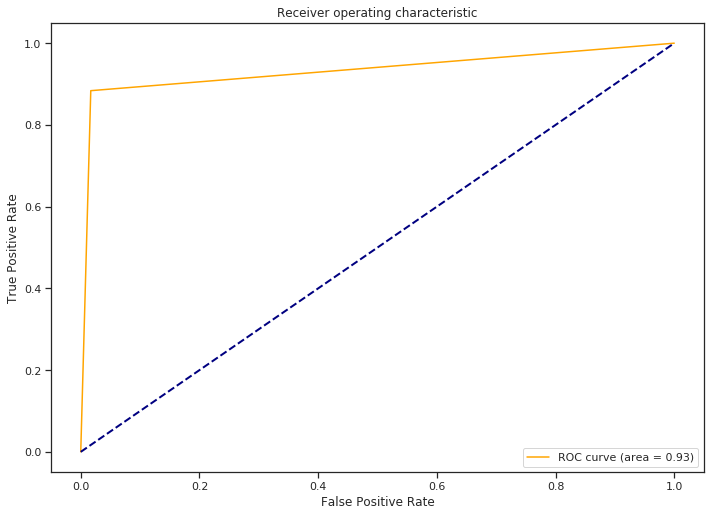

In [87]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(encoded_Y_test, pred)

roc_auc = auc(fpr, tpr)

sns.lineplot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Load the Globular Cluster data and do the following:
We only have 4 globular clusters to independently test the model on that is completely removed from our training data. This is, however, a good way to verify that the model is not overtrained and generalizes well to CFIS data. 
1. Apply cuts to proper motion and colors to show relevent CMD area
2. Remove any non-numbers
3. Convert the raw globular cluster columns to features (convert to color)
4. Normalize while convering to color
5. Predict the probabilities of being a dwarf/giant
6. Predict which class the prediction belongs to

In [88]:
inputs_NGC6341 = load_data_glob('./data/CFIS_PSf_Gaia_NGC6341.fits')
inputs_NGC6205 = load_data_glob('./data/CFIS_PSf_Gaia_NGC6205.fits')
inputs_NGC5466 = load_data_glob('./data/CFIS_PSf_Gaia_NGC5466.fits')
inputs_NGC5272 = load_data_glob('./data/CFIS_PSf_Gaia_NGC5272.fits')

##############################
## NGC 6341 ##
##############################
criteria = criteria_function(inputs_NGC6341, 0.2, 2.5, 0)
inputs_NGC6341 = inputs_NGC6341[criteria]
inputs_NGC6341 = (inputs_NGC6341.dropna())
inputs_NGC6341_b = change_to_colour(inputs_NGC6341, inputs_col)
inputs_NGC6341['dwarf'] =  rf.predict_proba(inputs_NGC6341_b.values)[:,0]
inputs_NGC6341['giant'] =  rf.predict_proba(inputs_NGC6341_b.values)[:,1]
inputs_NGC6341['class_binary'] =  rf.predict(inputs_NGC6341_b.values)


##############################
## NGC 6205 ##
##############################
criteria = criteria_function(inputs_NGC6205, 0.13, 2.5, 0)
inputs_NGC6205 = inputs_NGC6205[criteria]
inputs_NGC6205 = (inputs_NGC6205.dropna())
inputs_NGC6205_b = change_to_colour(inputs_NGC6205, inputs_col)
inputs_NGC6205['dwarf'] =  rf.predict_proba(inputs_NGC6205_b.values)[:,0]
inputs_NGC6205['giant'] =  rf.predict_proba(inputs_NGC6205_b.values)[:,1]
inputs_NGC6205['class_binary'] =  rf.predict(inputs_NGC6205_b.values)

##############################
## NGC 5466 ##
##############################
criteria = criteria_function(inputs_NGC5466, 0.26, 2.5, 0)
inputs_NGC5466 = inputs_NGC5466[criteria]
inputs_NGC5466 = (inputs_NGC5466.dropna())
inputs_NGC5466_b = change_to_colour(inputs_NGC5466, inputs_col)
inputs_NGC5466['dwarf'] =  rf.predict_proba(inputs_NGC5466_b.values)[:,0]
inputs_NGC5466['giant'] =  rf.predict_proba(inputs_NGC5466_b.values)[:,1]
inputs_NGC5466['class_binary'] =  rf.predict(inputs_NGC5466_b.values)

##############################
## NGC 5272 ##
##############################
criteria = criteria_function(inputs_NGC5272, 0.14, 2.5, 0)
inputs_NGC5272 = inputs_NGC5272[criteria]
inputs_NGC5272 = (inputs_NGC5272.dropna())
inputs_NGC5272_b = change_to_colour(inputs_NGC5272, inputs_col)
inputs_NGC5272['dwarf'] =  rf.predict_proba(inputs_NGC5272_b.values)[:,0]
inputs_NGC5272['giant'] =  rf.predict_proba(inputs_NGC5272_b.values)[:,1]
inputs_NGC5272['class_binary'] =  rf.predict(inputs_NGC5272_b.values)

Check the CMDs with color-coded predictions of dwarf or giant. Giants & dwarfs lay above and below the main sequence shutoff.
Show the luminosity function for the probability prediction, as well as the binary prediction of the model

**Warning! Is computationally heavy!**

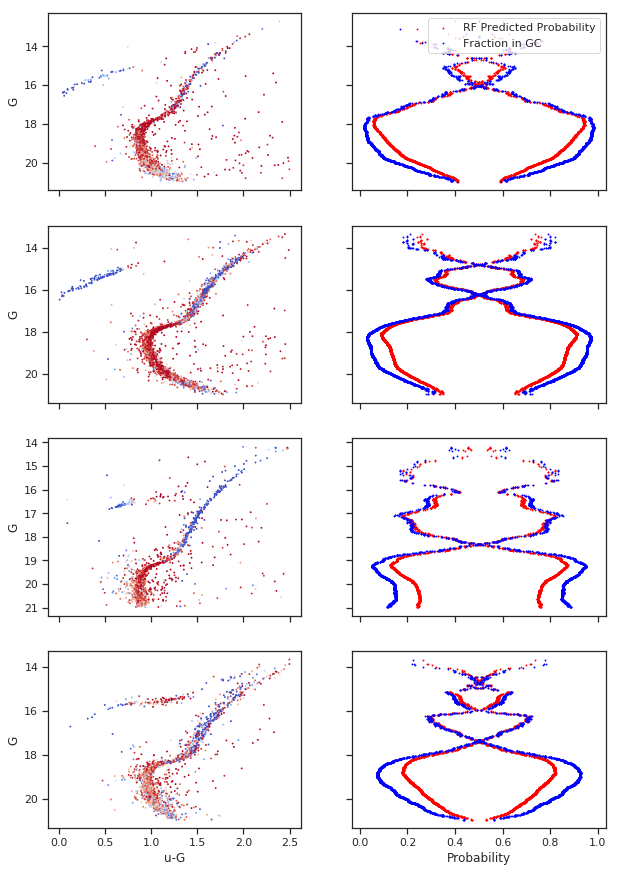

In [89]:
# Warning, takes a while to run..........

fig, ax = plt.subplots(4, 2, figsize=(10, 15),  sharex='col', sharey='row')

NGC6341_probs = prob_frac(0.5, inputs_NGC6341)
ax[0, 0].scatter((inputs_NGC6341['u']-inputs_NGC6341['G']).values, inputs_NGC6341['G'].values, s=0.75, c=inputs_NGC6341['dwarf'], cmap=plt.cm.coolwarm)
ax[0, 1].scatter(NGC6341_probs[0], NGC6341_probs[2], s=0.75, color='red', label='RF Predicted Probability')
ax[0, 1].scatter(NGC6341_probs[1], NGC6341_probs[2], s=0.75, color='red')
ax[0, 1].scatter(lum_frac(.5, inputs_NGC6341)[2], lum_frac(.5, inputs_NGC6341)[0], s=0.75, color='blue')
ax[0, 1].scatter(lum_frac(.5, inputs_NGC6341)[1], lum_frac(.5, inputs_NGC6341)[0], s=0.75, color='blue', label='Fraction in GC')
ax[0, 1].legend()
ax[0, 0].set_ylabel('G')
ax[0, 0].invert_yaxis()

NGC6205_probs = prob_frac(0.5, inputs_NGC6205)
ax[1, 0].scatter((inputs_NGC6205['u']-inputs_NGC6205['G']).values, inputs_NGC6205['G'].values, s=0.75, c=inputs_NGC6205['dwarf'], cmap=plt.cm.coolwarm)
ax[1, 1].scatter(NGC6205_probs[0], NGC6205_probs[2], s=0.75, color='red')
ax[1, 1].scatter(NGC6205_probs[1], NGC6205_probs[2], s=0.75, color='red')
ax[1, 1].scatter(lum_frac(.5, inputs_NGC6205)[2], lum_frac(.5, inputs_NGC6205)[0], s=0.75, color='blue')
ax[1, 1].scatter(lum_frac(.5, inputs_NGC6205)[1], lum_frac(.5, inputs_NGC6205)[0], s=0.75, color='blue')
ax[1, 0].set_ylabel('G')
ax[1, 0].invert_yaxis()

NGC5466_probs = prob_frac(0.5, inputs_NGC5466)
ax[2, 0].scatter((inputs_NGC5466['u']-inputs_NGC5466['G']).values, inputs_NGC5466['G'].values, s=0.75, c=inputs_NGC5466['dwarf'], cmap=plt.cm.coolwarm)
ax[2, 1].scatter(NGC5466_probs[0], NGC5466_probs[2], s=0.75, color='red')
ax[2, 1].scatter(NGC5466_probs[1], NGC5466_probs[2], s=0.75, color='red')
ax[2, 1].scatter(lum_frac(.5, inputs_NGC5466)[2], lum_frac(.5, inputs_NGC5466)[0], s=0.75, color='blue')
ax[2, 1].scatter(lum_frac(.5, inputs_NGC5466)[1], lum_frac(.5, inputs_NGC5466)[0], s=0.75, color='blue')
ax[2, 0].set_ylabel('G')
ax[2, 0].invert_yaxis()

NGC5272_probs = prob_frac(0.5, inputs_NGC5272)
ax[3, 0].scatter((inputs_NGC5272['u']-inputs_NGC5272['G']).values, inputs_NGC5272['G'].values, s=0.75, c=inputs_NGC5272['dwarf'], cmap=plt.cm.coolwarm)
ax[3, 1].scatter(NGC5272_probs[0], NGC5272_probs[2], s=0.75, color='red')
ax[3, 1].scatter(NGC5272_probs[1], NGC5272_probs[2], s=0.75, color='red')
ax[3, 1].scatter(lum_frac(.5, inputs_NGC5272)[2], lum_frac(.5, inputs_NGC5272)[0], s=0.75, color='blue')
ax[3, 1].scatter(lum_frac(.5, inputs_NGC5272)[1], lum_frac(.5, inputs_NGC5272)[0], s=0.75, color='blue')
ax[3, 0].invert_yaxis()
ax[3, 0].set_ylabel('G')
ax[3, 0].set_xlabel('u-G')
ax[3, 1].set_xlabel('Probability')
plt.savefig('./plots/rf_col/random_forrest')

Synthesize the lime results by reporting how important the features were for a fraction of the instances in the training set.

In [90]:
# KEEP FRAC SMALL UNLESS YOU WANT TO CALCULATE THIS FOR A LONG TIME!
# 0.001 is overly small, but is meant for testing and not for evaluating.
frac = 0.001
lime_synthesizer(rf, inputf_test, inputf_train, 1, 0,frac=0.001)

0
0 of 22
1 of 22
2 of 22
3 of 22
4 of 22
5 of 22
6 of 22
7 of 22
8 of 22
9 of 22
10 of 22
11 of 22
12 of 22
13 of 22
14 of 22
15 of 22
16 of 22
17 of 22
18 of 22
19 of 22
20 of 22
21 of 22
    low feature   high       val
6 -0.16     u-g  0.400 -0.148749
2 -0.69     r-i -0.140 -0.114915
1 -0.72     i-z  0.620 -0.105686
7 -0.43     z-y  0.135 -0.062641
0 -0.70     g-r -0.150 -0.021463
5 -0.73    u-RP  0.115 -0.004584
4 -0.73     u-G -0.160  0.002959
3 -0.74    u-BP -0.170  0.038944
